## Policy Iteration v/s Value Iteration

#### *pymdptoolbox* is a python library from which MDP examples can be imported </br>
##### Documentation of *pymdptoolbox* : https://pymdptoolbox.readthedocs.io/en/latest/api/mdptoolbox.html

In [5]:
!pip install pymdptoolbox   #Install pymdptoolbox within the code

## Import Required Libraries

In [1]:
import mdptoolbox.example
import numpy as np
import sys
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
warnings.filterwarnings('ignore')

## Class MarkovDP 

In [2]:
'''
Class MarkovDP contains the following attributes:
1)Number of states  : s
2)Number of actions : a
3)State Space
4)Action Space
5)Transition probability matrix of size (a,s,s)
6)Reward matrix (a,s,s)
'''
class MarkovDP:
    def __init__(self,s,a):
        self.num_state             = s
        self.num_action            = a
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))
        
# The function below initializes transition probability matrix and rewards marks 

    def initialize_mdp(self):      
        np.random.seed(0)        #for reproducibility 
        self.transitions, self.rewards = mdptoolbox.example.rand(self.num_state,self.num_action)
        self.rewards = np.random.rand(self.num_action,self.num_state,self.num_state)
        

## Policy Iteration Functions


In [3]:
# Policy Evaluation Function
def evaluate_policy(env, V, pi, gamma, theta):
    #print(V)
    #V = np.zeros((env.num_state,1))
    while True:
        delta = 0
        for s in env.states:
            v = V[s].copy()
            V=update_v_policy(env, V, pi, s, gamma)    #bellman update 
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    return V


# Bellman Update function
def update_v_policy(env, V, pi, s, gamma):
    sum=0
    for a in env.actions:
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        sum=sum+pi[s][a]*(np.sum(np.multiply(transitions,(rewards+(gamma*V)))))
    V[s]=sum
    return V

## Function that chooses the greedy action for a particular state 's'   
def choose_best_action_policy(env, V, pi, s, gamma):
    q=np.empty((env.num_action,1),dtype=float)
    for a in env.actions:
        pi[s][a]=0
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        q[a]=np.sum(np.multiply(transitions,(rewards+(gamma*V))))
    action=np.argmax(q)        #Choose greedy action
    p=np.zeros(env.num_action)            #Update Policy
    p[action]=1
    return p


    
# Policy Improvement Function
def improve_policy(env, V, pi, gamma):
    policy_stable = True        # If policy_stable == True : Policy need not be updated anymore
    for s in env.states:
        old = pi[s].copy()
        pi[s]=choose_best_action_policy(env, V, pi, s, gamma)
        if not np.array_equal(pi[s], old): 
            policy_stable = False
    return pi, policy_stable

# Policy Iteration
def policy_iteration(env, gamma, theta):
    V = np.zeros((env.num_state,1))          #Initialize Value function vector : [0,0,0...0]
    pi = np.ones((env.num_state,env.num_action)) / env.num_action   #Policy Initialization
    policy_stable = False
    i=0
    history=list()
    x=V.copy()
    history.append(x)           #save value function at each step of policy iteration to observe the policy improvement
    while not policy_stable:
        i+=1
        V= evaluate_policy(env, V, pi, gamma, theta)          #Policy Evaluation step
        pi, policy_stable = improve_policy(env, V, pi, gamma)  #Policy Iteration step
        x=V.copy()
        history.append(x)
    V= evaluate_policy(env, V, pi, gamma, theta) 
    x=V.copy()
    history.append(x)
    print('Total number of iterations:',i)
    return V, pi,history

## Value iteration Functions

In [11]:
# Bellman greedy update
def update_v_value(env, V, s, gamma):
    q=np.empty((env.num_action,1),dtype=float)
    for a in env.actions:
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        q[a]=np.sum(np.multiply(transitions,(rewards+(gamma*V))))
    action=np.argmax(q)
    return q[action]
    
    
## Function that chooses the greedy action for a particular state 's'   
def choose_best_action_value(env, V, pi, s, gamma):
    q=np.empty((env.num_action,1),dtype=float)
    for a in env.actions:
        pi[s][a]=0
        transitions = np.reshape(env.transitions[a][s][:],(-1,1))
        rewards = np.reshape(env.rewards[a][s][:],(-1,1))
        q[a]=np.sum(np.multiply(transitions,(rewards+(gamma*V))))
    action=np.argmax(q)        #Choose greedy action
    p=np.zeros(env.num_action)            #Update Policy
    p[action]=1
    return p
    
    
# Value Iteration
def value_iteration(env, gamma, theta):
    V = np.random.rand(env.num_state,1)
    i=0
    history=list()
    x=V.copy()
    history.append(x)   #save value function at each step of value iteration to observe policy improvement
    while True:
        i+=1
        delta = 0
        for s in env.states:
            v = V[s].copy()
            V[s]=update_v_value(env, V, s, gamma)             #Bellman greedy update
            delta = max(delta, abs(v - V[s]))
        x=V.copy()
        history.append(x)
        if delta < theta:
            break
    pi = np.ones((env.num_state, env.num_action))/ env.num_action   #Initialize policy
    for s in env.states:
        pi[s]=choose_best_action_value(env, V, pi, s, gamma)    #Update policy
    V= evaluate_policy(env, V, pi, gamma, theta)
    x=V.copy()
    history.append(x)
    print('Total number of iterations:',i)
    return V, pi,history

## Plot 

In [47]:
def plot_value(V_policy,history_policy,V_value,history_value,rho):
    
    plot_p = list()
    plot_v = list()
    for i in range(0,len(history_policy)):
        plot_p.append(np.sum(np.multiply(rho,np.array(history_policy[i]))))
    for i in range(0,len(history_value)):
        plot_v.append(np.sum(np.multiply(rho,np.array(history_value[i]))))

    plt.tick_params(axis='y',labelsize=9)
    plt.tick_params(axis='x',labelsize=9)
    plt.xlabel('Iterations', fontsize=12)
    plt.ylabel('Weighted Average Value Function', fontsize=12)
    plt.plot(range(0,len(history_policy)),plot_p,color='blue', label='Policy Iteration') 
    plt.plot(range(0,len(history_value)),plot_v, color='red', label='Value Iteration') 
    rho=np.array_str(np.reshape(rho,(1,-1)))
    title= 'Policy Iteration v/s Value Iteration, rho='+rho
    plt.title(title,fontsize=12)
    fig_size=(15,10)
    plt.rcParams["figure.figsize"] = fig_size
    plt.legend(loc='best') 
    plt.show()

## Comparing the two algorithms

In [48]:
'''
Define an MDP Environment : Insantiate Class
    Number of states : 10
    Number of actions : 3
'''
env= MarkovDP(10,3)      #Define an MDP Environment : Insantiate Class
env.initialize_mdp()    #Define P and R


### Policy Iteration

In [49]:
gamma = 0.9     #Discount rate
theta = 0.0001    #A small positive number

start_time = time.time()
V_policy,pi_policy,history_policy=policy_iteration(env, gamma, theta)
print("--- %s seconds ---" % (time.time() - start_time))



Total number of iterations: 3
--- 0.1085200309753418 seconds ---


### Value Iteration

In [50]:
gamma = 0.9     #Discount rate
theta = 0.0001    #A small positive number

start_time = time.time()
V_value,pi_value,history_value = value_iteration(env, gamma, theta)
print("--- %s seconds ---" % (time.time() - start_time))

Total number of iterations: 48
--- 0.07473206520080566 seconds ---


## Plot  $\rho\$ . V for both the algorithms

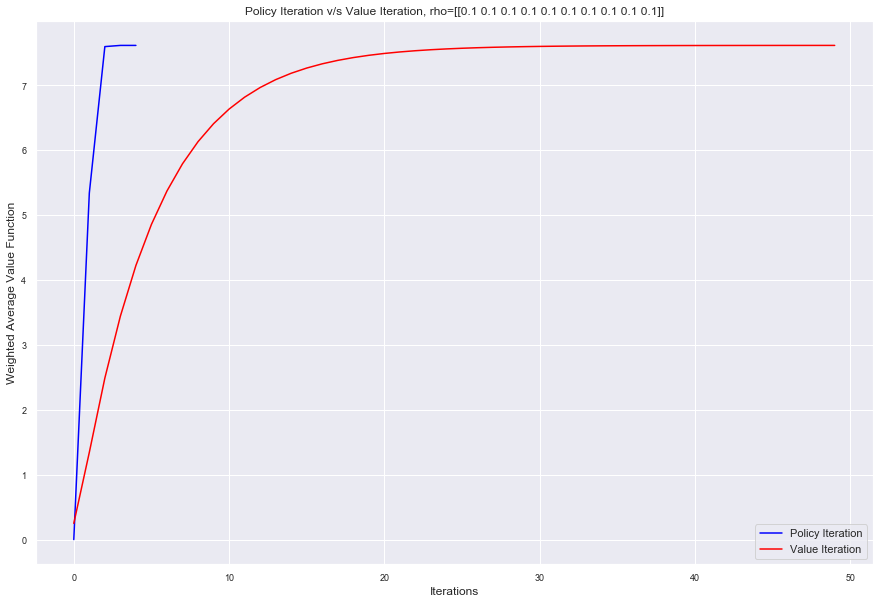

In [53]:
rho= np.ones((env.num_state,1))/env.num_state
plot_value(V_policy,history_policy,V_value,history_value,rho)